# Original CSV - Solve 2x2 Puzzle with 80/10/10 Split

In [1]:
import cv2
import numpy as np
import pandas as pd
import random
import glob
import csv
import keras
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Create function for tiles images

In [3]:
def tiles_images(img, pieces):
    img_width = img_height = img.shape[1] // pieces
    tiles_img = [img[x:x+img_height,y:y+img_width]
                 for x in range(0,img.shape[0], img_height)
                 for y in range(0,img.shape[1],img_width)
                ]

    new_tiles = []

    for img in tiles_img:
        if img.shape[0] == img_width and  img.shape[1] == img_height:
            new_tiles.append(img)

    return new_tiles

Create function for group images

In [4]:
def group_image(images, shuffle_arr, pieces=4):
    img = []

    print(shuffle_arr)

    new_order = [images[i] for i in shuffle_arr]

    for i in range(pieces):
        img.append(np.concatenate(new_order[i * pieces:(i + 1) * pieces], axis=1))

    img = np.concatenate(img, axis=0)
    return img

In [5]:
def load_data(base_path, path, pieces=2):
    data = pd.read_csv(base_path + '{}.csv'.format(path))
    path = base_path + path + '/'

    x, y = [], []
    for i in range(len(data)):
        im = Image.open(path + str(i) + '.jpg')
        im = np.array(im).astype('float16')
        im = im / 255 - 0.5

        if path.split('/')[-2] == 'test':
            x.append(im)
        else:
            x.append(tiles_images(im, pieces))

        label = data.iloc[i]
        label = [int(i) for i in label]
        y.append(label)

    return (np.array(x), np.expand_dims(np.array(y), axis=-1))

Define base path

In [6]:
base_path = "/content/drive/My Drive/668Project/puzzle_8020/"

Download data for train, test and validation

In [7]:
x_train, y_train = load_data(base_path, 'train')

In [8]:
x_val, y_val = load_data(base_path, 'valid')

In [9]:
x_test, y_test = load_data(base_path, 'test')

Train model for puzzle 2x2

In [10]:
import keras
from keras.layers import TimeDistributed as td
from keras.layers import Conv2D, Flatten, Dense, ZeroPadding2D, Activation
from keras.layers import MaxPooling2D, Dropout, BatchNormalization, Reshape

In [11]:
def get_model():

    model = keras.models.Sequential()

    model.add(td(ZeroPadding2D(2), input_shape=(4, 112, 112, 3)))

    model.add(td(Conv2D(50, kernel_size=(5,5), padding='same', activation='relu', strides=2)))
    model.add(td(BatchNormalization()))
    model.add(td(MaxPooling2D()))

    model.add(td(Conv2D(100, kernel_size=(5,5), padding='same', activation='relu', strides=2)))
    model.add(td(BatchNormalization()))
    model.add(td(Dropout(0.3)))

    model.add(td(Conv2D(100, kernel_size=(3,3), padding='same', activation='relu', strides=2)))
    model.add(td(BatchNormalization()))
    model.add(td(Dropout(0.3)))

    model.add(td(Conv2D(200, kernel_size=(3,3), padding='same', activation='relu', strides=1)))
    model.add(td(BatchNormalization()))
    model.add(td(Dropout(0.3)))

    model.add(Flatten())

    model.add(Dense(600, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(400, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(16))
    model.add(Reshape((4, 4)))
    model.add(Activation('softmax'))

    return model

In [12]:
model = get_model()

In [13]:
adam = keras.optimizers.Adam(learning_rate=.001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])

In [14]:
x_train.shape

(583, 4, 112, 112, 3)

In [15]:
y_train.shape

(583, 4, 1)

In [16]:
model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_val, y_val))

Epoch 1/100
10/10 [==============================] - 18s 205ms/step - loss: 2.0720 - sparse_categorical_accuracy: 0.2976 - val_loss: 1.3855 - val_sparse_categorical_accuracy: 0.2534
Epoch 2/100
10/10 [==============================] - 1s 107ms/step - loss: 1.1930 - sparse_categorical_accuracy: 0.5236 - val_loss: 1.3875 - val_sparse_categorical_accuracy: 0.3425
Epoch 3/100
10/10 [==============================] - 1s 108ms/step - loss: 0.8487 - sparse_categorical_accuracy: 0.6664 - val_loss: 1.3460 - val_sparse_categorical_accuracy: 0.3425
Epoch 4/100
10/10 [==============================] - 1s 116ms/step - loss: 0.6159 - sparse_categorical_accuracy: 0.7714 - val_loss: 1.3276 - val_sparse_categorical_accuracy: 0.3493
Epoch 5/100
10/10 [==============================] - 1s 92ms/step - loss: 0.4777 - sparse_categorical_accuracy: 0.8178 - val_loss: 1.4029 - val_sparse_categorical_accuracy: 0.3699
Epoch 6/100
10/10 [==============================] - 1s 95ms/step - loss: 0.3593 - sparse_categ

Check

1/1 [==============================] - 1s 808ms/step
[0 1 2 3]
1/1 [==============================] - 0s 100ms/step
[0 3 1 3]
1/1 [==============================] - 0s 34ms/step
[1 1 0 3]
1/1 [==============================] - 0s 75ms/step
[1 0 3 2]
1/1 [==============================] - 0s 35ms/step
[1 0 3 2]
1/1 [==============================] - 0s 66ms/step
[1 3 1 3]
1/1 [==============================] - 0s 131ms/step
[0 0 2 3]
1/1 [==============================] - 0s 17ms/step
[3 1 2 0]
1/1 [==============================] - 0s 17ms/step
[1 2 2 0]
1/1 [==============================] - 0s 19ms/step
[2 1 3 0]


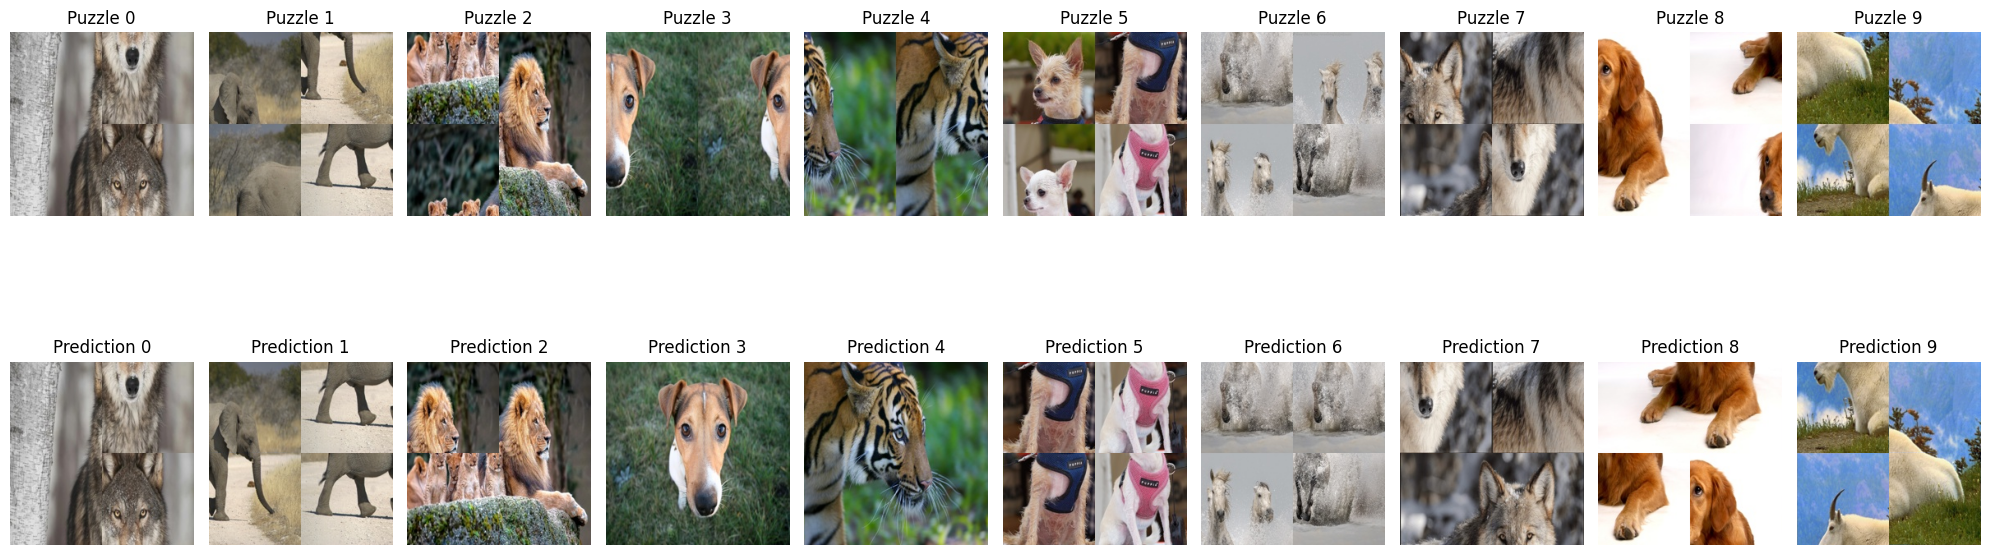

In [17]:
fig, axes = plt.subplots(2, 10, figsize=(20, 8))  # 2 rows, 10 columns

for i in range(10):
    image = x_test[i].astype('float64') + 0.5
    axes[0, i].imshow(image)
    axes[0, i].set_title(f"Puzzle {i}")
    axes[0, i].axis('off')

    inp = np.expand_dims(tiles_images(x_test[i], pieces=2), axis=0)
    y_pred = model.predict(inp)[0]
    y_pred = np.argmax(y_pred, axis=1)

    tiles = tiles_images(image, pieces=2)
    predit_img = group_image(tiles, y_pred, pieces=2)

    axes[1, i].imshow(predit_img)
    axes[1, i].set_title(f"Prediction {i}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Correctly solved: 2/10

# New CSV - Solve 2x2 Puzzle with 80/10/10 Split

Create function for tiles images

In [ ]:
def tiles_images(img, pieces):
    img_width = img_height = img.shape[1] // pieces
    tiles_img = [img[x:x+img_height,y:y+img_width]
                 for x in range(0,img.shape[0], img_height)
                 for y in range(0,img.shape[1],img_width)
                ]

    new_tiles = []

    for img in tiles_img:
        if img.shape[0] == img_width and  img.shape[1] == img_height:
            new_tiles.append(img)

    return new_tiles

Create function for group images

In [ ]:
def group_image(images, shuffle_arr, pieces=4):
    img = []

    print(shuffle_arr)

    new_order = [images[i] for i in shuffle_arr]

    for i in range(pieces):
        img.append(np.concatenate(new_order[i * pieces:(i + 1) * pieces], axis=1))

    img = np.concatenate(img, axis=0)
    return img

In [ ]:
def load_data(base_path, path, pieces=2):
    data = pd.read_csv(base_path + '{}1.csv'.format(path))
    path = base_path + path + '/'

    x, y = [], []
    for i in range(len(data)):
        im = Image.open(path + str(i) + '.jpg')
        im = np.array(im).astype('float16')
        im = im / 255 - 0.5

        if path.split('/')[-2] == 'test':
            x.append(im)
        else:
            x.append(tiles_images(im, pieces))

        label = data.iloc[i]
        label = [int(i) for i in label]
        y.append(label)

    return (np.array(x), np.expand_dims(np.array(y), axis=-1))

Define base path

In [ ]:
base_path = "/content/drive/My Drive/668Project/puzzle_8020/"

Download data for train, test and validation

In [ ]:
x_train, y_train = load_data(base_path, 'train')

In [ ]:
x_val, y_val = load_data(base_path, 'valid')

In [ ]:
x_test, y_test = load_data(base_path, 'test')

Train model for puzzle 2x2

In [ ]:
import keras
from keras.layers import TimeDistributed as td
from keras.layers import Conv2D, Flatten, Dense, ZeroPadding2D, Activation
from keras.layers import MaxPooling2D, Dropout, BatchNormalization, Reshape

In [ ]:
def get_model():

    model = keras.models.Sequential()

    model.add(td(ZeroPadding2D(2), input_shape=(4, 112, 112, 3)))

    model.add(td(Conv2D(50, kernel_size=(5,5), padding='same', activation='relu', strides=2)))
    model.add(td(BatchNormalization()))
    model.add(td(MaxPooling2D()))

    model.add(td(Conv2D(100, kernel_size=(5,5), padding='same', activation='relu', strides=2)))
    model.add(td(BatchNormalization()))
    model.add(td(Dropout(0.3)))

    model.add(td(Conv2D(100, kernel_size=(3,3), padding='same', activation='relu', strides=2)))
    model.add(td(BatchNormalization()))
    model.add(td(Dropout(0.3)))

    model.add(td(Conv2D(200, kernel_size=(3,3), padding='same', activation='relu', strides=1)))
    model.add(td(BatchNormalization()))
    model.add(td(Dropout(0.3)))

    model.add(Flatten())

    model.add(Dense(600, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(400, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(16))
    model.add(Reshape((4, 4)))
    model.add(Activation('softmax'))

    return model

In [ ]:
model = get_model()

In [ ]:
adam = keras.optimizers.Adam(learning_rate=.001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])

In [ ]:
x_train.shape

(583, 4, 112, 112, 3)

In [ ]:
y_train.shape

(583, 4, 1)

In [ ]:
model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_val, y_val))

Epoch 1/100
10/10 [==============================] - 20s 239ms/step - loss: 2.0704 - sparse_categorical_accuracy: 0.2860 - val_loss: 1.3780 - val_sparse_categorical_accuracy: 0.3322
Epoch 2/100
10/10 [==============================] - 1s 110ms/step - loss: 1.2319 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.3805 - val_sparse_categorical_accuracy: 0.2877
Epoch 3/100
10/10 [==============================] - 1s 101ms/step - loss: 0.9271 - sparse_categorical_accuracy: 0.6286 - val_loss: 1.3626 - val_sparse_categorical_accuracy: 0.3185
Epoch 4/100
10/10 [==============================] - 1s 96ms/step - loss: 0.7039 - sparse_categorical_accuracy: 0.7294 - val_loss: 1.3245 - val_sparse_categorical_accuracy: 0.3527
Epoch 5/100
10/10 [==============================] - 1s 95ms/step - loss: 0.5282 - sparse_categorical_accuracy: 0.8002 - val_loss: 1.3498 - val_sparse_categorical_accuracy: 0.3253
Epoch 6/100
10/10 [==============================] - 1s 95ms/step - loss: 0.3966 - sparse_catego

Check

1/1 [==============================] - 0s 358ms/step
[0 1 2 3]
1/1 [==============================] - 0s 20ms/step
[2 2 3 1]
1/1 [==============================] - 0s 20ms/step
[2 1 0 3]
1/1 [==============================] - 0s 19ms/step
[1 0 3 2]
1/1 [==============================] - 0s 24ms/step
[1 0 3 0]
1/1 [==============================] - 0s 19ms/step
[3 0 3 1]
1/1 [==============================] - 0s 24ms/step
[0 1 2 3]
1/1 [==============================] - 0s 26ms/step
[2 0 2 1]
1/1 [==============================] - 0s 25ms/step
[3 0 1 2]
1/1 [==============================] - 0s 18ms/step
[3 1 0 2]


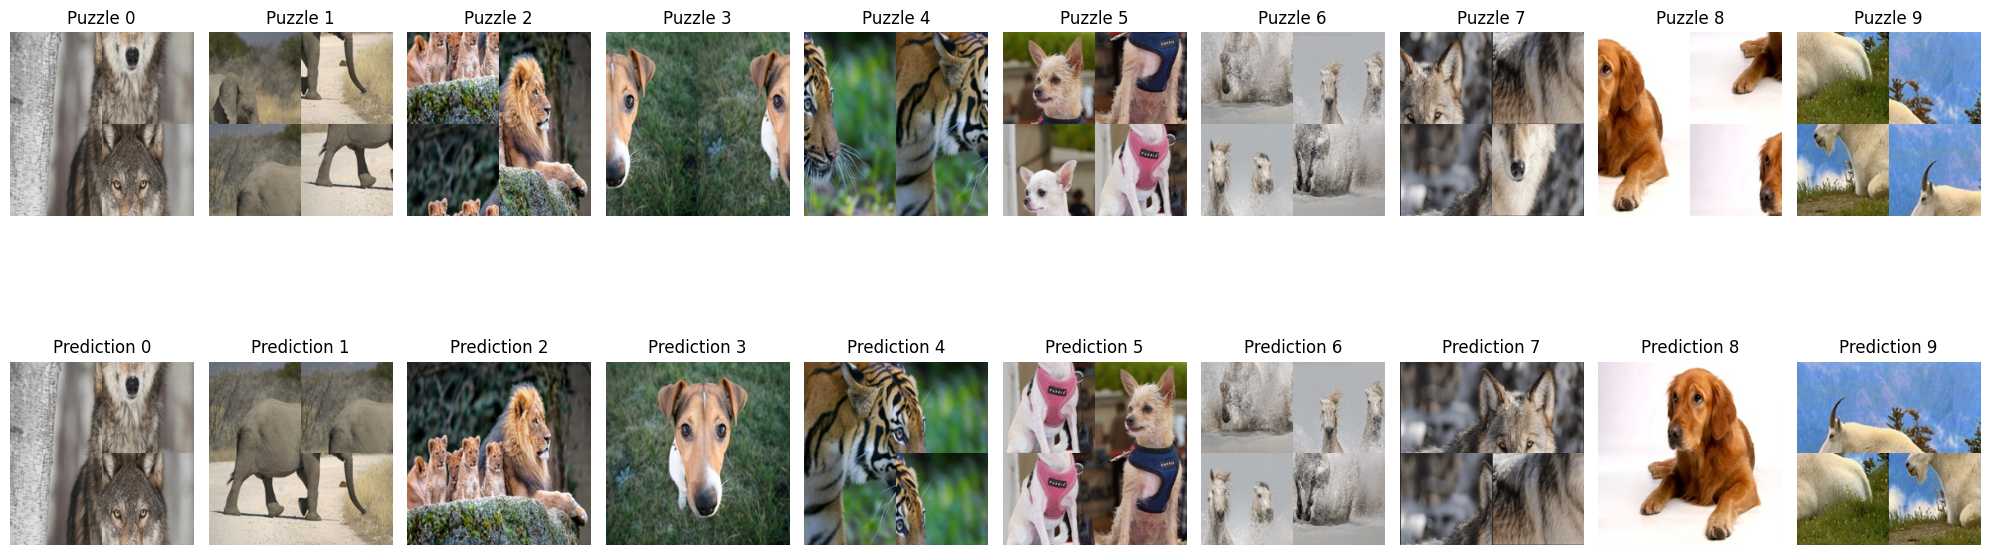

In [ ]:
fig, axes = plt.subplots(2, 10, figsize=(20, 8))  # 2 rows, 10 columns

for i in range(10):
    image = x_test[i].astype('float64') + 0.5
    axes[0, i].imshow(image)
    axes[0, i].set_title(f"Puzzle {i}")
    axes[0, i].axis('off')

    inp = np.expand_dims(tiles_images(x_test[i], pieces=2), axis=0)
    y_pred = model.predict(inp)[0]
    y_pred = np.argmax(y_pred, axis=1)

    tiles = tiles_images(image, pieces=2)
    predit_img = group_image(tiles, y_pred, pieces=2)

    axes[1, i].imshow(predit_img)
    axes[1, i].set_title(f"Prediction {i}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Correctly solved: 3/10